# Land Use and Land Cover Classification using Pytorch
**Content Creators**: Ankur Mahesh and Isabelle Tingzon

Welcome to CCAI's tutorial on land use and land cover (LULC) classification using Pytorch!

In this two-part tutorial, you will learn how to:
- train a deep learning model for image classification using Pytorch ([Part 1](https://colab.research.google.com/drive/1VI8kVLjJMSabIt9Bu4di_zYe9LtrMO5L?usp=sharing))
- generate land use and land cover maps using Python GIS ([Part 2](https://colab.research.google.com/drive/13I1wZT7thBlNdGA1tFQrK1MlRhMZMnpM?usp=sharing))

You can make a copy of this tutorial by File→Save a copy in Drive.

# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)

<a name="overview"></a>
# Overview
This tutorial covers an introduction to image classification using Pytorch for land use and land cover (LULC) mapping.

Specifically, you will learn how to:
- classify satellite images into 10 LULC categories using the [EuroSAT dataset](https://arxiv.org/abs/1709.00029)
- fine-tune a Resnet-50 CNN model for image classification
- save and load trained models in Pytorch




<a name="climate-impact"></a>
# Climate Impact
A [report](https://www.wri.org/insights/7-things-know-about-ipccs-special-report-climate-change-and-land) by the World Resources Institute (WRI) states that about 23% of global human-caused GHG emissions come from land uses such as agriculture, forestry, and urban expansion. Land use change such as deforestation and land degradation are among the primary drivers of these emissions. Rapid urbanization leading to an increase in built-up areas as well as a massive loss of terrestrial carbon storage can also result in large carbon emissions.

Mapping the extent of land use and land cover categories over time is essential for better environmental monitoring, urban planning and nature protection. For example, monitoring changes in forest cover and identifying drivers of forest loss can be useful for forest conservation and restoration efforts. Assessing the vulnerability of certain land cover types, such as settlements and agricultural land, to certain risks can also be useful for for disaster risk reduction planning as well as long-term climate adaptation efforts.

With the increasing availability of earth observation data coupled with recent advanced in computer vision, AI & EO has paved the way for the potential to map land use and land cover at an unprecedented scale. In this tutorial, we will explore the use of Sentinel-2 satellite images and deep learning models in Pytorch to automate LULC mapping.

<br>
<center><p><p> <img src="https://ptes.org/wp-content/uploads/2018/04/iStock-664630460-e1524839082464.jpg" alt="alt" width="50%"/>




<a name="target-audience"></a>
# Target Audience
This tutorial is intended for experienced and aspiring data scientists looking for concrete examples of the applications of deep learning in climate change. We expect users to have some background in machine learning, including neural networks. But don't worry if you are new to these topics! We will provide additional resources and external links below for you to further study.

<a name="background-and-prereqs"></a>
## Background and Prerequisites
For a refresher on neural networks, feel free to check out the video below by [3Blue1Brown](https://www.youtube.com/c/3blue1brown).

We also highly recommend [Stanford's lecture collection](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv) on convolutional neural networks (CNNs) for visual recognition. The deep learning specialization courses at [deeplearning.ai](https://www.deeplearning.ai/courses/) also provide an in-depth introduction to ANNs, CNNs, sequence models, and other deep learning concepts.

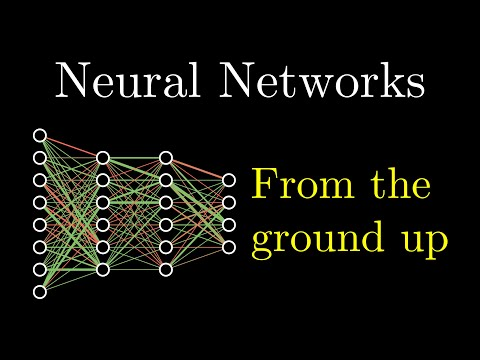

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('P28LKWTzrI')

<a name="software-requirements"></a>
# Software Requirements

This notebook requires Python >= 3.7. The following libraries are required:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

## Enabling GPU in Google Colab
Before we start, you will need access to a GPU.  Fortunately, Google Colab provides free access to computing resources including GPUs. The GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s. Unfortunately, there is no way to choose what type of GPU you can connect to in Colab. [See here for information](https://research.google.com/colaboratory/faq.html#gpu-availability).

To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

In [3]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Google Colab GPU
Check that the GPU  enabled in your colab notebook by running the cell below.

In [4]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA GeForce RTX 2080


## Mount Drive

Mounting the drive will allow the Google Colab notebook to load and access files from your Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="data-description"></a>
# Data Description

In this section, you will learn how to:
- Download the EuroSAT dataset into your Google Drive
- Generate the train and test sets by splitting the EuroSAT dataset
- Visualize a sample of the images and their LULC labels

## EuroSAT Dataset
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For simplicity, we will focus on RGB image classification.

In [5]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2023-08-01 23:42:34--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  9.60MB/s    in 6.5s    

2023-08-01 23:42:41 (13.9 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



## Generate Train and Test Sets

### Create Custom Dataset Class
In Pytorch, the `Dataset` class allows you to define a custom class to load the input and target for a dataset.  We will use this capability to load in our inputs in the form of RGB satellite images along with their corresponding labels. Later we'll learn how to apply necessary image transformations (see next section).

In [6]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

### Data Augmentation

Data augmentation is a  technique that randomly applies image transformations, e.g. crops, horizontal flips, and vertical flips, to the input images during model training. These perturbations reduce the neural network's overfitting to the training dataset, and they allow it to generalize better to the unseen test dataset.
<br><br>
<center> <img src="https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png" width="400"/>
</center>
<br>
<font size=2>Image Source: Ahmad, Jamil & Muhammad, Khan & Baik, Sung. (2017). Data augmentation-assisted deep learning of hand-drawn partially colored sketches for visual search. PLOS ONE. 12. e0183838. 10.1371/journal.pone.0183838. </font>
<br>


### Image Normalization
Additionally, in the cell below, the `transforms.Normalize` method normalizes each of the three channels to the given means and standard deviations defined in the `imagenet_mean` and `imagenet_std` variables. ImageNet is a large training dataset of images and labels.  Later in this tutorial, we will be using a model pre-trained on this dataset.  In order to use this pre-trained model for our LULC dataset, we need to ensure that the input dataset is normalized to have the same statistics (mean and standard deviation) as ImageNet.

<br>
<center> <img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg" width="400"/>
<br>
<font size=2>Image Source: https://cv.gluon.ai/build/examples_datasets/imagenet.html </font>
<br>
</center>

Existing research has found that using models pretrained on massive datasets, such as ImageNet, improves accuracy when applying these neural networks to new datasets.  Pre-trained models serve as excellent generic feature extractors.  [Please read here for more information](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [7]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Load EuroSAT Dataset
Let's start by loading the EuroSAT dataset using torch's `ImageFolder` class.

`ImageFolder` is a generic data loader where the images are arranged in this way:

```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```


In [8]:
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


### Split into Train and Test Sets
Here, we split the dataset into a train set and test set. The training set will be 80% of the Eurosat dataset, randomly selected. The remaining 20% of the dataset will be our test set.

In [9]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 80% train / 20% test
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


Finally, we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets.

In [10]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

## Visualize Data

In the cell below, we will visualize a batch of the dataset.  The cell visualizes the input to the neural network (the RGB image) along with the associated label.

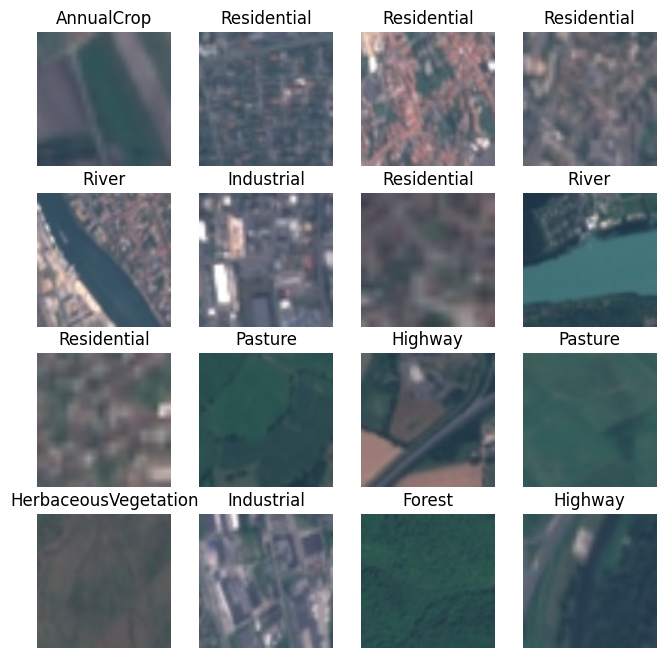

In [11]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

# Exploratory Data Analysis

Next, let's explore our dataset a little bit more.  In particular, how many images of each class are included?

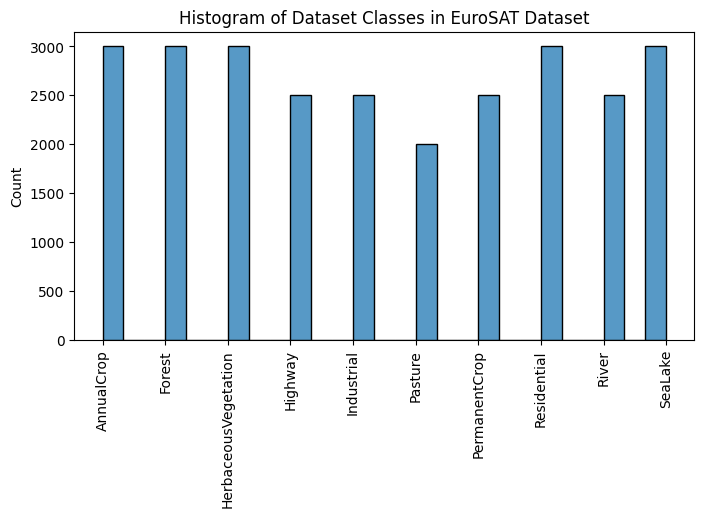

In [12]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

# Model Development

## Instantiate Model

First, let's instatiate the model.  To start, we will use a standard neural network architecture, called ResNet50. Based on [the work by Helber et al.](https://arxiv.org/pdf/1709.00029.pdf), ResNet-50 has been shown to work well for LULC classification on the EuroSAT

### ResNet-50
<b>Recall</b>: Deep neural networks are difficult to train due to the problem of vanishing or exploding gradients (repeated multiplication making the gradient infinitively small). ResNet solves this by using shortcut connections that connect activation from an earlier layer to a further layer by skipping one or more layers as shown below. This allows for gradients to propagate to the deeper layers before they can be reduced to small or zero values.
<br><br>

<center> <img src="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png" width="600"/><br>
Image source: <a href="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/">https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/  </a>
</center>
<br>
Note that when we load the model, we set the `pre-trained` flag to be True to indicate that the loaded model should be already pre-trained on the Imagenet dataset.

In [13]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

torchsummary.summary(model, (3, 224, 224))

/mnt/wsl/PHYSICALDRIVE1p1/@home/non/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/wsl/PHYSICALDRIVE1p1/@home/non/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/non/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.5MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

In the next cell, we'll define our criterion and optimizer.

### Cross Entropy Loss
We define our loss as the cross-entropy loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. ([Source](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

For two classes, it is computed as:

$−ylog(p)-(1−y)log(1−p)$

For multiclass classification with $M$ classes, it is defined as:

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

where

- $M$ - number of classes (dog, cat, fish)
- $log$ - the natural log
- $y_{o,c}$ - binary indicator (0 or 1) if class label $c$ is the classification for observation $o$
- $p_{o,c}$- predicted probability observation $o$ is of class $c$

### Stochastic Gradient Descent
Remember that the goal of stochastic gradient descent (SGD) is to minimize the loss function. To do this, it computes the slope (gradient) of the loss function at the current point and moves in the opposite direction of the slope towards the steepest descent.
<center> <img src="https://miro.medium.com/max/1400/1*P7z2BKhd0R-9uyn9ThDasA.png" width="350"/><br>Image source:
<a href="https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a">https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a</a>
</center>
<br>

In [14]:
n_epochs = 5
lr = 1e-3 #1e-2, 1e-5

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Next. let's create our train function.

In [15]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

Next, let's define the model evaluation function.

In [16]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

Putting it all together, we can now commence training and evaluation in the following cell.

In [17]:
# Keep track of the best loss and
# best model weights with the lowest loss
best_loss = np.inf
best_model = None

# Train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, train_loader, criterion, optimizer)
  test_loss, _ = evaluate(model, test_loader, criterion)

  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

Epoch 1


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.99; Accuracy: 71.65


  0%|          | 0/338 [00:00<?, ?it/s]

Test Loss: 0.31; Accuracy: 92.19
Epoch 2


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.46; Accuracy: 85.55


  0%|          | 0/338 [00:00<?, ?it/s]

Test Loss: 0.17; Accuracy: 95.44
Epoch 3


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.37; Accuracy: 88.11


  0%|          | 0/338 [00:00<?, ?it/s]

Test Loss: 0.12; Accuracy: 96.50
Epoch 4


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.32; Accuracy: 89.80


  0%|          | 0/338 [00:00<?, ?it/s]

Test Loss: 0.11; Accuracy: 96.44
Epoch 5


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.28; Accuracy: 91.25


  0%|          | 0/338 [00:00<?, ?it/s]

Test Loss: 0.10; Accuracy: 97.17


## Save Model

We can now save the model to our local Google drive as follows.


In [18]:
model_dir = "./models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = model_dir + 'best_model.pth'
torch.save(best_model, model_file)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to ./models/best_model.pth


## Load Model
Here we show you how to load the saved model from the previous step.

In [19]:
model_dir = "./models/"
model_file = os.path.join(model_dir, 'best_model.pth')

# Uncomment this to download the model file
#if not os.path.isfile(model_file):
#  model_file = 'best_model.pth'
#  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./models/best_model.pth successfully loaded.


<a name="results-and-discussion"></a>
# Results & Discussion

Let's visualize an example of the neural network making a prediction.

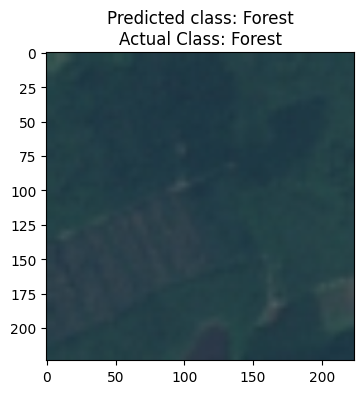

In [22]:
# Retrieve sample image
index = 12
image, label = test_data[index]

# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

Here, we show how to run the model on a PIL image.

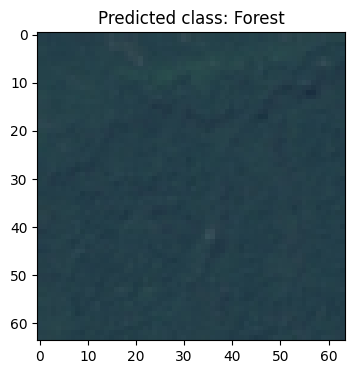

In [23]:
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_2.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

Congrats on making it this far! Go to the next section, [Part 2: Automating Land Use and Land Cover Mapping using Python.](https://colab.research.google.com/drive/13I1wZT7thBlNdGA1tFQrK1MlRhMZMnpM?usp=sharing).

## Exercises (Optional)

### Experiments for Model Improvement
1. As an exercise, try exploring different CNN architectures. You can find more information on the different CNN classification models in Pytorch [here](https://pytorch.org/vision/0.8/models.html).
2. Try out other types of data augmentation techniques. You can learn more about using Pytorch for data transformation and augmentation [in this link](https://pytorch.org/vision/main/transforms.html).
3. Try implementing hyperparameter tuning, e.g tweaking the learning rate, number of epochs, and check for model improvement or degradation.

### Exploring the Effects of Pre-training [For Advanced ML Practitioners]

Earlier, we mentioned that we are using a pre-trained model to train the neural network on the Eurosat LULC dataset.  Let's explore how much pre-training helps in this next section.  As an exercise, try comparing the performance of three variants of the neural network:

1. Fine-tuned: in this setup, the neural network uses a pre-trained set of weights as a starting point, and all the weights are updated as the model is trained.
2. Fixed feature extractor: in this setup, the neural network uses a pre-trained set of weights as a starting point, and only the weights of the last layer are updated.
3. Trained from scratch: this neural network uses no pre-trained weights.

# References
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.